# Setup

In [ ]:
!pip install tensorboardX
!pip install gym
!pip install roboschool

     |████████████████████████████████| 245kB 1.9MB/s 
     |████████████████████████████████| 44.9MB 1.3MB/s 


# Imports

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import gym
#import roboschool
import sys

In [2]:
pip show module gym

Name: gym
Version: 0.10.4
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: 
Location: c:\users\hamza\anaconda3\lib\site-packages
Requires: numpy, pyglet, requests, six
Required-by: roboschool
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip show module roboschool

Name: roboschool
Version: 1.0.34
Summary: OpenAI Household Simulator: mobile manipulation using Bullet
Home-page: https://github.com/openai/roboschool
Author: 
Author-email: 
License: UNKNOWN
Location: c:\users\hamza\anaconda3\lib\site-packages
Requires: gym
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gym==0.10.4


     ---------------------------------------- 1.5/1.5 MB 23.7 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gym: filename=gym-0.10.4-py3-none-any.whl size=1581528 sha256=d0940d586a1944713ac03daa889b4ce7796016d585ee1afb254ec589ff4bb09d
  Stored in directory: c:\users\hamza\appdata\local\pip\cache\wheels\30\a5\99\adcb204fd5063b97a86c5b1e8c6a3a0b2cbdc7ec78838e079d
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.15.4
    Uninstalling gym-0.15.4:
      Successfully uninstalled gym-0.15.4


In [4]:
pip install roboschool==1.0.48

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement roboschool==1.0.48 (from versions: 1.0.1, 1.0.3, 1.0.6, 1.0.7, 1.0.8, 1.0.15, 1.0.16, 1.0.17, 1.0.18, 1.0.19, 1.0.20, 1.0.34)
ERROR: No matching distribution found for roboschool==1.0.48


# Networks

In [ ]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [ ]:
class Actor(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            action output of network with tanh activation
    """
    
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action


    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x)) 
        return x



In [ ]:
class Critic(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            value output of network 
    """
    
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)


    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2


    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1

# Memory

In [ ]:
# Expects tuples of (state, next_state, action, reward, done)
class ReplayBuffer(object):
    """Buffer to store tuples of experience replay"""
    
    def __init__(self, max_size=1000000):
        """
        Args:
            max_size (int): total amount of tuples to store
        """
        
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        """Add experience tuples to buffer
        
        Args:
            data (tuple): experience replay tuple
        """
        
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Samples a random amount of experiences from buffer of batch size
        
        Args:
            batch_size (int): size of sample
        """
        
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, next_states, rewards, dones = [], [], [], [], []

        for i in ind: 
            s, a, s_, r, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            next_states.append(np.array(s_, copy=False))
            rewards.append(np.array(r, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(next_states), np.array(rewards).reshape(-1, 1), np.array(dones).reshape(-1, 1)

# Agent

In [ ]:
class TD3(object):
    """Agent class that handles the training of the networks and provides outputs as actions
    
        Args:
            state_dim (int): state size
            action_dim (int): action size
            max_action (float): highest action to take
            device (device): cuda or cpu to process tensors
            env (env): gym environment to use
    
    """
    
    def __init__(self, state_dim, action_dim, max_action, env):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.env = env


        
    def select_action(self, state, noise=0.1):
        """Select an appropriate action from the agent policy
        
            Args:
                state (array): current state of environment
                noise (float): how much noise to add to acitons
                
            Returns:
                action (float): action clipped within action range
        
        """
        
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise != 0: 
            action = (action + np.random.normal(0, noise, size=self.env.action_space.shape[0]))
            
        return action.clip(self.env.action_space.low, self.env.action_space.high)

    
    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        """Train and update actor and critic networks
        
            Args:
                replay_buffer (ReplayBuffer): buffer for experience replay
                iterations (int): how many times to run training
                batch_size(int): batch size to sample from replay buffer
                discount (float): discount factor
                tau (float): soft update for main networks to target networks
                
            Return:
                actor_loss (float): loss from actor network
                critic_loss (float): loss from critic network
        
        """
        
        for it in range(iterations):

            # Sample replay buffer 
            x, y, u, r, d = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(x).to(device)
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)
            done = torch.FloatTensor(1 - d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(u).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) 

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))


    def load(self, filename="best_avg", directory="./saves"):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

In [ ]:
class ProbabilisticRoadmap:

    def __init__(self, map_dim, start_pose, start_radius, goal_pose, goal_radius, obstacles, k):
        self.map_dim = self.mapx, self.mapy = map_dim
        self.start_pose = self.sx, self.sy = start_pose
        self.start_radius = start_radius
        self.goal_pose = self.gx, self.gy = goal_pose
        self.goal_radius = goal_radius
        self.obstacles = obstacles
        self.k = k
        self.nodes = []
        self.network_created = False

    def sample(self, sample_size):
        self.network_created = False
        self.nodes = []
        self.add_node(0, *self.start_pose)
        for i in range(sample_size):
            n = len(self.nodes)
            collision = True
            x, y = (-1, -1)
            while collision:
                x, y = self.sample_envir()
                collision = self.on_obstacle((x, y))
            self.add_node(n, x, y)
        return self.nodes

    def sample_envir(self):
        x = int(random.uniform(0, self.mapx))
        y = int(random.uniform(0, self.mapy))
        return x, y

    def on_obstacle(self, point):
        for obs in self.obstacles:
            if obs.collidepoint(point):
                return True
        return False

    def add_node(self, n, x, y):
        self.nodes.insert(n, Node(x, y, n))

    def remove_node(self, n):
        self.nodes.pop(n)

    def set_obstacles(self, obstacles):
        self.obstacles = obstacles

    def cross_obstacle(self, start_pos, end_pos):
        sx, sy = start_pos[0], start_pos[1]
        ex, ey = end_pos[0], end_pos[1]

        for obs in self.obstacles:
            for i in range(100):
                u = i / 100
                x = sx * u + ex * (1 - u)
                y = sy * u + ey * (1 - u)
                if obs.collidepoint(x, y):
                    return True
        return False

    def find_k_nearest(self, n, k):
        k_dists = {}
        for i in range(k + 1):
            d = dist_to_node(self.nodes[i], n)
            k_dists[d] = self.nodes[i]

        for i in range(len(self.nodes)):
            nn = self.nodes[i]
            d = dist_to_node(nn, n)
            if d not in k_dists.keys():
                max_dist = max(k_dists.keys())
                if d < max_dist:
                    k_dists.pop(max_dist)
                    k_dists[d] = nn

        return k_dists.values()

    def connect(self, n1, n2):
        if self.cross_obstacle(n1.get_coords(), n2.get_coords()):
            return False
        else:
            add_edge(n1, n2)

    def add_edges(self, n):
        k_nearest = self.find_k_nearest(n, self.k)
        for node in k_nearest:
            self.connect(n, node)
        return n

    def update_edges_gt(self, n):
        k_nearest = self.find_k_nearest(n, self.k)
        for node in k_nearest:
            if node in n.adj:
                continue
            self.connect(n, node)
        return n

    def update_edges_lt(self, n):
        k_nearest = self.find_k_nearest(n, self.k)
        adj = n.adj.copy()
        for node in adj:
            if node in k_nearest:
                continue
            else:
                del n.adj[node]
                del n.edge[node]
        return n

    def find_node_in_radius(self, p, r):
        x = p[0]
        y = p[1]
        if len(self.nodes) == 0:
            return None
        max_dist = r
        closest_node = None
        for node in self.nodes:
            d = dist_to_point(node, p)
            if d <= max_dist:
                max_dist = d
                xx, yy = node.get_coords()
                if (x - xx) ** 2 + (y - yy) ** 2 <= r ** 2:
                    closest_node = node
        return closest_node

    def get_start_node(self):
        return self.find_node_in_radius(self.start_pose, self.start_radius)

    def get_end_node(self):
        return self.find_node_in_radius(self.goal_pose, self.goal_radius)

    def create_network(self, surf, nr, neighbours):
        if (self.network_created):
            return
        self.k = neighbours
        for node in self.nodes:
            node.adj = {}
            node.edge = {}
            self.add_edges(node)
            node.draw(surf, nr, 1)
        self.network_created = True

    def update_network_gt(self):
        for node in self.nodes:
            self.update_edges_gt(node)

    def update_network_lt(self):
        for node in self.nodes:
            self.update_edges_lt(node)

    def update_k(self, k):
        for node in self.nodes:
            node.search = None
            node.parent = None
        if k > self.k:
            self.k = k
            self.update_network_gt()
        elif k < self.k:
            self.k = k
            self.update_network_lt()

    def update_pose(self, sp, gp):
        self.start_pose = sp
        self.goal_pose = gp

# Runner

In [ ]:
class Runner():
    """Carries out the environment steps and adds experiences to memory"""
    
    def __init__(self, env, agent, replay_buffer):
        
        self.env = env
        self.agent = agent
        self.replay_buffer = replay_buffer
        self.obs = env.reset()
        self.done = False
        
    def next_step(self, episode_timesteps, noise=0.1):
        
        action = self.agent.select_action(np.array(self.obs), noise=0.1)
        
        # Perform action
        new_obs, reward, done, _ = self.env.step(action) 
        done_bool = 0 if episode_timesteps + 1 == 200 else float(done)
    
        # Store data in replay buffer
        replay_buffer.add((self.obs, new_obs, action, reward, done_bool))
        
        self.obs = new_obs
        
        if done:
            self.obs = self.env.reset()
            done = False
            
            return reward, True
        
        return reward, done

# Evaluate

In [ ]:
def evaluate_policy(policy, env, eval_episodes=100,render=False):
    """run several episodes using the best agent policy
        
        Args:
            policy (agent): agent to evaluate
            env (env): gym environment
            eval_episodes (int): how many test episodes to run
            render (bool): show training
        
        Returns:
            avg_reward (float): average reward over the number of evaluations
    
    """
    
    avg_reward = 0.
    for i in range(eval_episodes):
        obs = env.reset()
        done = False
        while not done:
            if render:
                env.render()
            action = policy.select_action(np.array(obs), noise=0)
            obs, reward, done, _ = env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    print("\n---------------------------------------")
    print("Evaluation over {:d} episodes: {:f}" .format(eval_episodes, avg_reward))
    print("---------------------------------------")
    return avg_reward

# Observation

In [ ]:
def observe(env,replay_buffer, observation_steps):
    """run episodes while taking random actions and filling replay_buffer
    
        Args:
            env (env): gym environment
            replay_buffer(ReplayBuffer): buffer to store experience replay
            observation_steps (int): how many steps to observe for
    
    """
    
    time_steps = 0
    obs = env.reset()
    done = False

    while time_steps < observation_steps:
        action = env.action_space.sample()
        new_obs, reward, done, _ = env.step(action)

        replay_buffer.add((obs, new_obs, action, reward, done))

        obs = new_obs
        time_steps += 1

        if done:
            obs = env.reset()
            done = False

        print("\rPopulating Buffer {}/{}.".format(time_steps, observation_steps), end="")
        sys.stdout.flush()

# Train

In [ ]:
def train(agent, test_env):
    """Train the agent for exploration steps
    
        Args:
            agent (Agent): agent to use
            env (environment): gym environment
            writer (SummaryWriter): tensorboard writer
            exploration (int): how many training steps to run
    
    """

    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    done = False 
    obs = env.reset()
    evaluations = []
    rewards = []
    best_avg = -2000
    
    writer = SummaryWriter(comment="-TD3_Baseline_HalfCheetah")
    
    while total_timesteps < EXPLORATION:
    
        if done: 

            if total_timesteps != 0: 
                rewards.append(episode_reward)
                avg_reward = np.mean(rewards[-100:])
                
                writer.add_scalar("avg_reward", avg_reward, total_timesteps)
                writer.add_scalar("reward_step", reward, total_timesteps)
                writer.add_scalar("episode_reward", episode_reward, total_timesteps)
                
                if best_avg < avg_reward:
                    best_avg = avg_reward
                    print("saving best model....\n")
                    #agent.save("best_avg","saves")

                print("\rTotal T: {:d} Episode Num: {:d} Reward: {:f} Avg Reward: {:f}".format(
                    total_timesteps, episode_num, episode_reward, avg_reward), end="")
                sys.stdout.flush()


                if avg_reward >= REWARD_THRESH:
                    break

                agent.train(replay_buffer, episode_timesteps, BATCH_SIZE, GAMMA, TAU, NOISE, NOISE_CLIP, POLICY_FREQUENCY)

                # Evaluate episode
                if timesteps_since_eval >= EVAL_FREQUENCY:
                    timesteps_since_eval %= EVAL_FREQUENCY
                    eval_reward = evaluate_policy(agent, test_env)
                    evaluations.append(avg_reward)
                    writer.add_scalar("eval_reward", eval_reward, total_timesteps)

                    if best_avg < eval_reward:
                        best_avg = eval_reward
                        print("saving best model....\n")
                        #agent.save("best_avg","saves")

                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1 

        reward, done = runner.next_step(episode_timesteps)
        episode_reward += reward

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1

# Config

In [ ]:
ENV = "RoboschoolHalfCheetah-v1"#"Pendulum-v0"
SEED = 0
OBSERVATION = 10000
EXPLORATION = 5000000
BATCH_SIZE = 100
GAMMA = 0.99
TAU = 0.005
NOISE = 0.2
NOISE_CLIP = 0.5
EXPLORE_NOISE = 0.1
POLICY_FREQUENCY = 2
EVAL_FREQUENCY = 5000
REWARD_THRESH = 8000

# Main

In [ ]:
env = gym.make(ENV)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

policy = TD3(state_dim, action_dim, max_action, env)

replay_buffer = ReplayBuffer()

runner = Runner(env, policy, replay_buffer)

total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True

In [ ]:
# Populate replay buffer
observe(env, replay_buffer, OBSERVATION)

Populating Buffer 10000/10000.

In [ ]:
# Train agent
train(policy, env)

saving best model....

Total T: 1349 Episode Num: 57 Reward: 10.917738 Avg Reward: 18.075233saving best model....

Total T: 1399 Episode Num: 58 Reward: 56.090791 Avg Reward: 18.719565saving best model....

Total T: 1457 Episode Num: 61 Reward: 16.567969 Avg Reward: 18.660640saving best model....

Total T: 1493 Episode Num: 62 Reward: 34.659701 Avg Reward: 18.914593saving best model....

Total T: 1524 Episode Num: 63 Reward: 29.989922 Avg Reward: 19.087645saving best model....

Total T: 1564 Episode Num: 64 Reward: 43.543056 Avg Reward: 19.463882saving best model....

Total T: 1598 Episode Num: 65 Reward: 23.621033 Avg Reward: 19.526869saving best model....

Total T: 1647 Episode Num: 66 Reward: 49.553500 Avg Reward: 19.975028saving best model....

Total T: 1678 Episode Num: 67 Reward: 34.354363 Avg Reward: 20.186489saving best model....

Total T: 1725 Episode Num: 68 Reward: 42.118331 Avg Reward: 20.504341saving best model....

Total T: 1813 Episode Num: 69 Reward: 38.718639 Avg Rewar

KeyboardInterrupt: ignored

In [5]:
from numpy import sin, cos
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Circle, Ellipse
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pydrake.all import MathematicalProgram, Jacobian, SolutionResult, Variables, LinearQuadraticRegulator
import math
import time
from multiprocessing import Process, Value, Array
#import rospy
import subprocess
from os import path
#import alpyro_msgs.visualization_msgs.marker as Marker
#import alpyro_msgs.visualization_msgs.markerarray as MarkerArray
from numpy import inf
import random
#from gazebo_msgs.msg import ModelState
from squaternion import Quaternion
#from alpyro_msgs.geometry_msgs import twist as Twist
#from alpyro_msgs.sensor_msgs import laserscan, pointcloud2
#import alpyro_msgs.sensor_msgs.pointcloud2 as pc2
#import alpyro_msgs.sensor_msgs.laserscan as LaserScan
#import alpyro_msgs.nav_msgs.odometry as Odometry
#import alpyro_msgs.std_msgs.empty as Empty
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter
import gym
import sys
import roboschool
#from PathPlanning.VisibilityRoadMap.geometry import Geometry
#sys.path.append(os.path.dirname(os.path.abspath(__file__)) +
 #               "/../VoronoiRoadMap/")
#from dijkstra_search import DijkstraSearch

ModuleNotFoundError: No module named 'pydrake.all'

In [10]:
pip install drake

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement drake (from versions: none)
ERROR: No matching distribution found for drake


## Simulation Run

In [ ]:
from numpy import sin, cos
import numpy as np

# These are only for plotting
import matplotlib.animation as animation
from matplotlib.patches import Circle, Ellipse
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from pydrake.all import MathematicalProgram, Jacobian, SolutionResult, Variables, LinearQuadraticRegulator

import math

### MILPSOS operation ### 

class MILPSOS():

	def __init__(self, ang_discret=5, rng_discret=5):
		fov = np.deg2rad(70)
		self.theta = fov/2.
		self.max_range = 3. 
		self.min_range = 0.5
		self.ang_discret = ang_discret # number of discretizations for angs
		self.rng_discret = rng_discret # number of discretizations for range
		self.angles = np.linspace(-self.theta, self.theta, ang_discret) # discretize
		spacing = (self.max_range - self.min_range)/rng_discret
		self.ranges = np.linspace(self.min_range, self.max_range + spacing, rng_discret) # discretize

	def quad_dynamics(self, state, u, dt):
		# u input here are the velocities xd, yd
		new_state = np.zeros_like(state)
		new_state[2:] = u
		new_state[:2] = state[:2] + dt*u
		# might check the accuracy of this later
		return new_state

	def plot_trajectory(self, trajectory, obst_idx, x_margin=None, y_margin=None):
		'''
		Given a trajectory and an input_trajectory, plots this trajectory and control inputs over time.

		:param: trajectory: the output of simulate_states_over_time, or equivalent
			Note: see simulate_states_over_time for documentation of the shape of the output
		:param: input_trajectory: the input to simulate_states_over_time, or equivalent
			Note: see simulate_states_over_time for documentation of the shape of the input_trajectory
		:param: obst_idx: where the obstacles are 

		also plots environment 
		'''
		position_x = trajectory[:,0]
		position_y = trajectory[:,1]
		fig, axes = plt.subplots(nrows=1,ncols=1)
		axes.plot(position_x, position_y)

		for i in range(len(obst_idx) - 1):
			if int(obst_idx[i]) < (self.rng_discret - 1): # less than max range measured
				pts = np.zeros([4,2])
				ang_min = self.angles[i] # lower angle bound of obstacle 
				ang_max = self.angles[i+1] # higher angle bound of obstaclee 
				rng_min = self.ranges[int(obst_idx[i])] # where the obst is at at this angle 
				rng_max = self.ranges[int(obst_idx[i] + 1)] 
				ang = (ang_min + ang_max)/2.
				rng = (rng_min + rng_max)/2.
				pts[0,:] = np.array([rng_min*cos(ang_min), rng_min*np.sin(ang_min)])
				pts[1,:] = np.array([rng_max*cos(ang_min), rng_max*np.sin(ang_min)])
				pts[2,:] = np.array([rng_max*cos(ang_max), rng_max*np.sin(ang_max)])
				pts[3,:] = np.array([rng_min*cos(ang_max), rng_min*np.sin(ang_max)])
				poly = Polygon(pts, facecolor="black", edgecolor='black', fill=True ,linewidth = 1.0, linestyle='solid')
				axes.add_patch(poly)

		if x_margin != None and y_margin != None:
			for i in range(1,trajectory.shape[0]):
				rad = np.arctan((trajectory[i,1] - trajectory[i-1,1])/(trajectory[i,0] - trajectory[i-1,0]))
				theta = np.rad2deg(rad)
				x = trajectory[i,0]; y = trajectory[i,1]
				reg = Ellipse((x,y),width=x_margin,height=y_margin, angle=theta, alpha=0.5)
				axes.add_patch(reg)

		axes.axis('equal')

		plt.show()

	def plot_grid(self):
		scan_x1 = np.ones([20])*(0.8*np.cos(-self.theta)) + 0.1*np.random.random([20,])
		scan_y1 = np.linspace(0.8*np.sin(-self.theta),0,20)
		scan_x2 = np.ones([30])*(2.5*np.cos(self.theta)) + 0.1*np.random.random([30,])
		scan_y2 = np.linspace(0, 2.5*np.sin(self.theta),30) 
		fig, axes = plt.subplots(nrows=1,ncols=1)
		axes.plot(scan_x1, scan_y1, color='red', markersize=24)
		axes.plot(scan_x2, scan_y2, color='red', markersize=24)
		for i in range(self.ang_discret - 1):
			for j in range(self.rng_discret - 1): # less than max range measured
				pts = np.zeros([4,2])
				ang_min = self.angles[i] # lower angle bound of obstacle 
				ang_max = self.angles[i+1] # higher angle bound of obstaclee 
				rng_min = self.ranges[j] # where the obst is at at this angle 
				rng_max = self.ranges[j + 1] 
				ang = (ang_min + ang_max)/2.
				rng = (rng_min + rng_max)/2.
				pts[0,:] = np.array([rng_min*cos(ang_min), rng_min*np.sin(ang_min)])
				pts[1,:] = np.array([rng_max*cos(ang_min), rng_max*np.sin(ang_min)])
				pts[2,:] = np.array([rng_max*cos(ang_max), rng_max*np.sin(ang_max)])
				pts[3,:] = np.array([rng_min*cos(ang_max), rng_min*np.sin(ang_max)])
				poly = Polygon(pts, facecolor="black", edgecolor='black', fill=False ,linewidth = 1.0, linestyle='solid')
				axes.add_patch(poly)

		obst_idx = [0, 0, 2, 2, 2]
		for i in range(len(obst_idx) - 1):
			if int(obst_idx[i]) < (self.rng_discret - 1): # less than max range measured
				pts = np.zeros([4,2])
				ang_min = self.angles[i] # lower angle bound of obstacle 
				ang_max = self.angles[i+1] # higher angle bound of obstaclee 
				rng_min = self.ranges[int(obst_idx[i])] # where the obst is at at this angle 
				rng_max = self.ranges[int(obst_idx[i] + 1)] 
				ang = (ang_min + ang_max)/2.
				rng = (rng_min + rng_max)/2.
				pts[0,:] = np.array([rng_min*cos(ang_min), rng_min*np.sin(ang_min)])
				pts[1,:] = np.array([rng_max*cos(ang_min), rng_max*np.sin(ang_min)])
				pts[2,:] = np.array([rng_max*cos(ang_max), rng_max*np.sin(ang_max)])
				pts[3,:] = np.array([rng_min*cos(ang_max), rng_min*np.sin(ang_max)])
				poly = Polygon(pts, facecolor="black", edgecolor='black', fill=True ,linewidth = 1.0, linestyle='solid')
				axes.add_patch(poly)

		axes.axis('equal')

		plt.show()

	def MILP_compute_traj(self, obst_idx, x_out, y_out, dx, dy, pose_initial=[0.,0.]):
		'''
		Find trajectory with MILP
		Outputs trajectory (waypoints) and new K for control 
		'''
		mp = MathematicalProgram()
		N = 8
		k = 0
		# define state traj
		st = mp.NewContinuousVariables(2, "state_%d" % k)
		# # binary variables for obstalces constraint 
		c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
		obs = c
		states = st
		for k in range(1, N):
			st = mp.NewContinuousVariables(2, "state_%d" % k)
			states = np.vstack((states, st))
			c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
			obs = np.vstack((obs, c))
		st = mp.NewContinuousVariables(2, "state_%d" % (N + 1))
		states = np.vstack((states, st))
		c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
		obs = np.vstack((obs, c))
		# variables encoding max x y dist from obstacle 
		x_margin = mp.NewContinuousVariables(1, "x_margin")
		y_margin = mp.NewContinuousVariables(1, "y_margin")
		### define cost
		for i in range(N):
			mp.AddLinearCost(-states[i,0]) # go as far forward as possible
		mp.AddLinearCost(-states[-1,0])
		mp.AddLinearCost(-x_margin[0])
		mp.AddLinearCost(-y_margin[0])
		# bound x y margin so it doesn't explode 
		mp.AddLinearConstraint(x_margin[0] <= 3.)
		mp.AddLinearConstraint(y_margin[0] <= 3.)
		# x y is non ngative adn at least above robot radius
		mp.AddLinearConstraint(x_margin[0] >= 0.05)
		mp.AddLinearConstraint(y_margin[0] >= 0.05)
		M = 1000 # slack var for integer things
		# state constraint
		for i in range(2): # initial state constraint x y
			mp.AddLinearConstraint(states[0,i] <= pose_initial[i])
			mp.AddLinearConstraint(states[0,i] >= pose_initial[i])
		for i in range(N): 
			mp.AddQuadraticCost((states[i+1,1] - states[i,1])**2)
			mp.AddLinearConstraint(states[i+1,0] <= states[i,0] + dx)
			mp.AddLinearConstraint(states[i+1,0] >= states[i,0] - dx)
			mp.AddLinearConstraint(states[i+1,1] <= states[i,1] + dy)
			mp.AddLinearConstraint(states[i+1,1] >= states[i,1] - dy)
			# obstacle constraint 
			for j in range(self.ang_discret - 1):
				mp.AddLinearConstraint(sum(obs[i,4*j:4*j+4]) <= 3)
				ang_min = self.angles[j] # lower angle bound of obstacle 
				ang_max = self.angles[j+1] # higher angle bound of obstaclee 
				if int(obst_idx[j]) < (self.rng_discret - 1): # less than max range measured
					rng_min = self.ranges[int(obst_idx[j])] # where the obst is at at this angle 
					rng_max = self.ranges[int(obst_idx[j] + 1)] 
					mp.AddLinearConstraint(states[i,0] <= rng_min - x_margin[0] + M*obs[i,4*j]) # xi <= xobs,low + M*c
					mp.AddLinearConstraint(states[i,0] >= rng_max + x_margin[0] - M*obs[i,4*j+1]) # xi >= xobs,high - M*c 
					mp.AddLinearConstraint(states[i,1] <= states[i,0]*np.tan(ang_min) - y_margin[0] + M*obs[i,4*j+2]) # yi <= xi*tan(ang,min) + M*c
					mp.AddLinearConstraint(states[i,1] >= states[i,0]*np.tan(ang_max) + y_margin[0] - M*obs[i,4*j+3]) # yi >= ci*tan(ang,max) - M*c
		# obstacle constraint for last state
		for j in range(self.ang_discret - 1):
			mp.AddLinearConstraint(sum(obs[N,4*j:4*j+4]) <= 3)
			ang_min = self.angles[j] # lower angle bound of obstacle 
			ang_max = self.angles[j+1] # higher angle bound of obstaclee 
			if int(obst_idx[j]) < (self.rng_discret - 1): # less than max range measured
				rng_min = self.ranges[int(obst_idx[j])] # where the obst is at at this angle 
				rng_max = self.ranges[int(obst_idx[j] + 1)] 
				mp.AddLinearConstraint(states[N,0] <= rng_min - x_margin[0] + M*obs[N,4*j]) # xi <= xobs,low + M*c
				mp.AddLinearConstraint(states[N,0] >= rng_max + x_margin[0] - M*obs[N,4*j+1]) # xi >= xobs,high - M*c 
				mp.AddLinearConstraint(states[N,1] <= states[N,0]*np.tan(ang_min) - y_margin[0] + M*obs[N,4*j+2]) # yi <= xi*tan(ang,min) + M*c
				mp.AddLinearConstraint(states[N,1] >= states[N,0]*np.tan(ang_max) + y_margin[0] - M*obs[N,4*j+3]) # yi >= ci*tan(ang,max) - M*c


		mp.Solve()

		trajectory = mp.GetSolution(states)
		xm = mp.GetSolution(x_margin)
		ym = mp.GetSolution(y_margin)
		x_out[:] = trajectory[:,0]
		y_out[:] = trajectory[:,1]
		return trajectory, xm[0], ym[0]

	def get_dxdy(self, rho, S, sample=100):
		# from an optimized rho, and the current V (polynomial?), find dx dy 
		# randomly sample dx dy
		upper_y = 0.3
		upper_x = 0.3
		lower_y = 0.
		lower_x = 0.
		lower_vval = 0
		for i in range(sample):
			dx = (upper_x - lower_x)*np.random.random() + lower_x
			dy = (upper_y - lower_y)*np.random.random() + lower_y
			V_val = self.calcV(S, dx, dy)
			if V_val < rho and V_val > lower_vval:
				lower_x = dx
				lower_y = dy
				lower_vval = V_val
		return lower_x, lower_y, lower_vval

	def get_new_S(self, rho, xm, ym):
		# get new S from the xy margins
		S = np.eye(2)
		S[0,0] = rho/(xm*xm)
		S[1,1] = rho/(ym*ym)
		return S

	def calcV(self, S, dx, dy):
		x_ = np.array([dx, dy])
		return x_.dot(np.dot(S, x_))

	def calcS(self, K):
		# in my quadrotor case, S = K
		return K 

	def calcU(self, u_coeff, x):
		a = u_coeff
		return a[5] + a[1]*x[0]*x[1] + a[4]*x[0] + a[2]*x[0]*x[0] + a[3]*x[1] + a[0]*x[1]*x[1]

	def dynamics(self, x, u):
		xd = u[0,0].ToExpression()
		yd = u[1,0].ToExpression()
		return np.array([xd, yd])

	def dynamics_ucoeff(self, x, ux_coeff, uy_coeff):
		xd = self.calcU(ux_coeff, x)
		yd = self.calcU(uy_coeff, x)
		return np.array([xd, yd])

	def dynamics_K(self, x, K):
		xd = -K[0]*x[0]
		yd = -K[1]*x[1]
		return np.array([xd, yd])

	def dynamics_K_sat1(self, x, K):
		# upper saturated xd 
		xd = 2.5
		yd = -K[1]*x[1]
		return np.array([xd, yd])

	def dynamics_K_sat2(self, x, K):
		# lower saturated xd 
		xd = -2.5
		yd = -K[1]*x[1]
		return np.array([xd, yd])

	def dynamics_K_sat3(self, x, K):
		# upper saturated yd 
		xd = -K[0]*x[0]
		yd = 2.5 
		return np.array([xd, yd])

	def dynamics_K_sat4(self, x, K):
		# lower saturated yd 
		xd = -K[0]*x[0]
		yd = -2.5
		return np.array([xd, yd])

	def SOS_compute_1(self, S, rho_prev):
		# fix V and rho, search for L and u
		prog = MathematicalProgram()
		x = prog.NewIndeterminates(2, "x")

		# Define u 
		K = prog.NewContinuousVariables(2, "K")

		# Fixed Lyapunov
		V = x.dot(np.dot(S, x))
		Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

		# Define the Lagrange multipliers.
		(lambda_, constraint) = prog.NewSosPolynomial(Variables(x), 2)
		prog.AddLinearConstraint(K[0]*x[0] <= 0)
		prog.AddSosConstraint(-Vdot - lambda_.ToExpression() * (rho_prev - V))

		result = prog.Solve()
		# print(lambda_.ToExpression())
		# print(lambda_.decision_variables())
		lc = [prog.GetSolution(var) for var in lambda_.decision_variables()]
		lbda_coeff = np.ones([3,3])
		lbda_coeff[0,0] = lc[0]; lbda_coeff[0,1] = lbda_coeff[1,0] = lc[1]; lbda_coeff[2,0] = lbda_coeff[0,2] = lc[2]
		lbda_coeff[1,1] = lc[3]; lbda_coeff[2,1] = lbda_coeff[1,2] = lc[4]; lbda_coeff[2,2] = lc[5]
		return lbda_coeff

	def SOS_compute_2(self, l_coeff, S, rho_max=10.):
		prog = MathematicalProgram()
		# fix V and lbda, searcu for u and rho
		x = prog.NewIndeterminates(2, "x")
		# get lbda from before 
		l = np.array([x[1], x[0], 1])
		lbda = l.dot(np.dot(l_coeff, l))

		# Define u 
		K = prog.NewContinuousVariables(2, "K")

		# Fixed Lyapunov
		V = x.dot(np.dot(S, x))
		Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

		# rho is decision variable now 
		rho = prog.NewContinuousVariables(1, "rho")[0]

		prog.AddSosConstraint(-Vdot - lbda * (rho - V))

		prog.AddLinearConstraint(rho <= rho_max)
		prog.AddLinearCost(-rho)
		prog.Solve()
		rho = prog.GetSolution(rho)
		K = prog.GetSolution(K)
		return rho, K

	def SOS_compute_3(self, K, l_coeff, rho_max=10.):
		prog = MathematicalProgram()
		# fix u and lbda, search for V and rho 
		x = prog.NewIndeterminates(2, "x")

		# get lbda from before 
		l = np.array([x[1], x[0], 1])
		lbda = l.dot(np.dot(l_coeff, l))

		# rho is decision variable now 
		rho = prog.NewContinuousVariables(1, "rho")[0]

		# create lyap V 
		s = prog.NewContinuousVariables(4, "s")
		S = np.array([[s[0], s[1]], [s[2], s[3]]])
		V = x.dot(np.dot(S, x))
		Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

		prog.AddSosConstraint(V)
		prog.AddSosConstraint(-Vdot - lbda * (rho - V))

		prog.AddLinearCost(-rho)
		prog.AddLinearConstraint(rho <= rho_max)

		prog.Solve()
		rho = prog.GetSolution(rho)
		s = prog.GetSolution(s)
		return s, rho

	def SOS_compute_4(self, l_coeff, S, rho):
		prog = MathematicalProgram()
		# fix V and lbda, searcu for u and rho
		x = prog.NewIndeterminates(2, "x")
		# get lbda from before 
		l = np.array([x[1], x[0], 1])
		lbda = l.dot(np.dot(l_coeff, l))

		# Define u 
		K = prog.NewContinuousVariables(2, "K")

		# Fixed Lyapunov
		V = x.dot(np.dot(S, x))
		Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

		prog.AddSosConstraint(-Vdot - lbda * (rho - V))

		prog.Solve()
		K = prog.GetSolution(K)
		return rho, K

	def create_LQR(self): # as initialization 
		Q = np.eye(2)
		R = np.eye(2)
		A = np.zeros([2,2])
		B = np.eye(2)

		K, S = LinearQuadraticRegulator(A, B, Q, R)

		return K, S

In [ ]:
from numpy import sin, cos
import numpy as np

# These are only for plotting
import matplotlib.animation as animation
from matplotlib.patches import Circle, Ellipse
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from pydrake.all import MathematicalProgram, Jacobian, SolutionResult, Variables, LinearQuadraticRegulator
import math
%reload_ext autoreload
%autoreload 2
import time
from multiprocessing import Process, Value, Array

In [ ]:
### MILPSOS operation ### 

class MILPSOS():

    def __init__(self, ang_discret=5, rng_discret=5):
        fov = np.deg2rad(70)
        self.theta = fov/2.
        self.max_range = 3. 
        self.min_range = 0.5
        self.ang_discret = ang_discret # number of discretizations for angs
        self.rng_discret = rng_discret # number of discretizations for range
        self.angles = np.linspace(-self.theta, self.theta, ang_discret) # discretize
        spacing = (self.max_range - self.min_range)/rng_discret
        self.ranges = np.linspace(self.min_range, self.max_range + spacing, rng_discret) # discretize

    def quad_dynamics(self, state, u, dt):
        # u input here are the velocities xd, yd
        new_state = np.zeros_like(state)
        new_state[2:] = u
        new_state[:2] = state[:2] + dt*u
        # might check the accuracy of this later
        return new_state

    def plot_trajectory(self, trajectory, obst_idx, x_margin=None, y_margin=None):
        '''
        :param: trajectory: the output of simulate_states_over_time, or equivalent
        Note: see simulate_states_over_time for documentation of the shape of the output
        :param: input_trajectory: the input to simulate_states_over_time, or equivalent
        Note: see simulate_states_over_time for documentation of the shape of the input_trajectory
        :param: obst_idx: where the obstacles are 
        also plots environment 
        '''
        position_x = trajectory[:,0]
        position_y = trajectory[:,1]
        fig, axes = plt.subplots(nrows=1,ncols=1)
        axes.plot(position_x, position_y)
        for i in range(len(obst_idx) - 1):
            if int(obst_idx[i]) < (self.rng_discret - 1): # less than max range measured
                pts = np.zeros([4,2])
                ang_min = self.angles[i] # lower angle bound of obstacle 
                ang_max = self.angles[i+1] # higher angle bound of obstaclee 
                rng_min = self.ranges[int(obst_idx[i])] # where the obst is at at this angle 
                rng_max = self.ranges[int(obst_idx[i] + 1)] 
                ang = (ang_min + ang_max)/2.
                rng = (rng_min + rng_max)/2.
                pts[0,:] = np.array([rng_min*cos(ang_min), rng_min*np.sin(ang_min)])
                pts[1,:] = np.array([rng_max*cos(ang_min), rng_max*np.sin(ang_min)])
                pts[2,:] = np.array([rng_max*cos(ang_max), rng_max*np.sin(ang_max)])
                pts[3,:] = np.array([rng_min*cos(ang_max), rng_min*np.sin(ang_max)])
                poly = Polygon(pts, facecolor="black", edgecolor='black', fill=True ,linewidth = 1.0, linestyle='solid')
                axes.add_patch(poly)

        if x_margin != None and y_margin != None:
            for i in range(1,trajectory.shape[0]):
                rad = np.arctan((trajectory[i,1] - trajectory[i-1,1])/(trajectory[i,0] - trajectory[i-1,0]))
                theta = np.rad2deg(rad)
                x = trajectory[i,0]; y = trajectory[i,1]
                reg = Ellipse((x,y),width=x_margin,height=y_margin, angle=theta, alpha=0.5)
                axes.add_patch(reg)

        axes.axis('equal')
        plt.show()

    def plot_grid(self):
        scan_x1 = np.ones([20])*(0.8*np.cos(-self.theta)) + 0.1*np.random.random([20,])
        scan_y1 = np.linspace(0.8*np.sin(-self.theta),0,20)
        scan_x2 = np.ones([30])*(2.5*np.cos(self.theta)) + 0.1*np.random.random([30,])
        scan_y2 = np.linspace(0, 2.5*np.sin(self.theta),30) 
        fig, axes = plt.subplots(nrows=1,ncols=1)
        axes.plot(scan_x1, scan_y1, color='red', markersize=24)
        axes.plot(scan_x2, scan_y2, color='red', markersize=24)
        for i in range(self.ang_discret - 1):
            for j in range(self.rng_discret - 1): # less than max range measured
                pts = np.zeros([4,2])
                ang_min = self.angles[i] # lower angle bound of obstacle 
                ang_max = self.angles[i+1] # higher angle bound of obstaclee 
                rng_min = self.ranges[j] # where the obst is at at this angle 
                rng_max = self.ranges[j + 1] 
                ang = (ang_min + ang_max)/2.
                rng = (rng_min + rng_max)/2.
                pts[0,:] = np.array([rng_min*cos(ang_min), rng_min*np.sin(ang_min)])
                pts[1,:] = np.array([rng_max*cos(ang_min), rng_max*np.sin(ang_min)])
                pts[2,:] = np.array([rng_max*cos(ang_max), rng_max*np.sin(ang_max)])
                pts[3,:] = np.array([rng_min*cos(ang_max), rng_min*np.sin(ang_max)])
                poly = Polygon(pts, facecolor="black", edgecolor='black', fill=False ,linewidth = 1.0, linestyle='solid')
                axes.add_patch(poly)

        obst_idx = [0, 0, 2, 2, 2]
        for i in range(len(obst_idx)-1):
            if int(obst_idx[i]) < (self.rng_discret - 1): # less than max range measured
                pts = np.zeros([4,2])
                ang_min = self.angles[i] # lower angle bound of obstacle 
                ang_max = self.angles[i+1] # higher angle bound of obstaclee 
                rng_min = self.ranges[int(obst_idx[i])] # where the obst is at at this angle 
                rng_max = self.ranges[int(obst_idx[i] + 1)] 
                ang = (ang_min + ang_max)/2.
                rng = (rng_min + rng_max)/2.
                pts[0,:] = np.array([rng_min*cos(ang_min), rng_min*np.sin(ang_min)])
                pts[1,:] = np.array([rng_max*cos(ang_min), rng_max*np.sin(ang_min)])
                pts[2,:] = np.array([rng_max*cos(ang_max), rng_max*np.sin(ang_max)])
                pts[3,:] = np.array([rng_min*cos(ang_max), rng_min*np.sin(ang_max)])
                poly = Polygon(pts, facecolor="black", edgecolor='black', fill=True ,linewidth = 1.0, linestyle='solid')
                axes.add_patch(poly)

        axes.axis('equal')
        plt.show()

    def MILP_compute_traj(self, obst_idx, x_out, y_out, dx, dy, pose_initial=[0.,0.]):
        '''
        Find trajectory with MILP
        Outputs trajectory (waypoints) and new K for control '''
        mp = MathematicalProgram()
        N = 8
        k = 0
        # define state traj
        st = mp.NewContinuousVariables(2, "state_%d" % k)
        # # binary variables for obstalces constraint 
        c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
        obs = c
        states = st
        for k in range(1, N):
            st = mp.NewContinuousVariables(2, "state_%d" % k)
            states = np.vstack((states, st))
            c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
            obs = np.vstack((obs, c))
        st = mp.NewContinuousVariables(2, "state_%d" % (N + 1))
        states = np.vstack((states, st))
        c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
        obs = np.vstack((obs, c))
        # variables encoding max x y dist from obstacle 
        x_margin = mp.NewContinuousVariables(1, "x_margin")
        y_margin = mp.NewContinuousVariables(1, "y_margin")
        ### define cost
        for i in range(N):
            mp.AddLinearCost(-states[i,0]) # go as far forward as possible
        mp.AddLinearCost(-states[-1,0])
        mp.AddLinearCost(-x_margin[0])
        mp.AddLinearCost(-y_margin[0])
        # bound x y margin so it doesn't explode 
        mp.AddLinearConstraint(x_margin[0] <= 3.)
        mp.AddLinearConstraint(y_margin[0] <= 3.)
        # x y is non ngative adn at least above robot radius
        mp.AddLinearConstraint(x_margin[0] >= 0.05)
        mp.AddLinearConstraint(y_margin[0] >= 0.05)
        M = 1000 # slack var for integer things
        # state constraint
        for i in range(2): # initial state constraint x y
            mp.AddLinearConstraint(states[0,i] <= pose_initial[i])
            mp.AddLinearConstraint(states[0,i] >= pose_initial[i])
        for i in range(N): 
            mp.AddQuadraticCost((states[i+1,1] - states[i,1])**2)
            mp.AddLinearConstraint(states[i+1,0] <= states[i,0] + dx)
            mp.AddLinearConstraint(states[i+1,0] >= states[i,0] - dx)
            mp.AddLinearConstraint(states[i+1,1] <= states[i,1] + dy)
            mp.AddLinearConstraint(states[i+1,1] >= states[i,1] - dy)
            # obstacle constraint 
            for j in range(self.ang_discret - 1):
                mp.AddLinearConstraint(sum(obs[i,4*j:4*j+4]) <= 3)
                ang_min = self.angles[j] # lower angle bound of obstacle 
                ang_max = self.angles[j+1] # higher angle bound of obstaclee 
                if int(obst_idx[j]) < (self.rng_discret - 1): # less than max range measured
                    rng_min = self.ranges[int(obst_idx[j])] # where the obst is at at this angle 
                    rng_max = self.ranges[int(obst_idx[j] + 1)] 
                    mp.AddLinearConstraint(states[i,0] <= rng_min - x_margin[0] + M*obs[i,4*j]) # xi <= xobs,low + M*c
                    mp.AddLinearConstraint(states[i,0] >= rng_max + x_margin[0] - M*obs[i,4*j+1]) # xi >= xobs,high - M*c 
                    mp.AddLinearConstraint(states[i,1] <= states[i,0]*np.tan(ang_min) - y_margin[0] + M*obs[i,4*j+2]) # yi <= xi*tan(ang,min) + M*c
                    mp.AddLinearConstraint(states[i,1] >= states[i,0]*np.tan(ang_max) + y_margin[0] - M*obs[i,4*j+3]) # yi >= ci*tan(ang,max) - M*c
        # obstacle constraint for last state
        for j in range(self.ang_discret - 1):
            mp.AddLinearConstraint(sum(obs[N,4*j:4*j+4]) <= 3)
            ang_min = self.angles[j] # lower angle bound of obstacle 
            ang_max = self.angles[j+1] # higher angle bound of obstaclee 
            if int(obst_idx[j]) < (self.rng_discret - 1): # less than max range measured
                rng_min = self.ranges[int(obst_idx[j])] # where the obst is at at this angle 
                rng_max = self.ranges[int(obst_idx[j] + 1)] 
                mp.AddLinearConstraint(states[N,0] <= rng_min - x_margin[0] + M*obs[N,4*j]) # xi <= xobs,low + M*c
                mp.AddLinearConstraint(states[N,0] >= rng_max + x_margin[0] - M*obs[N,4*j+1]) # xi >= xobs,high - M*c 
                mp.AddLinearConstraint(states[N,1] <= states[N,0]*np.tan(ang_min) - y_margin[0] + M*obs[N,4*j+2]) # yi <= xi*tan(ang,min) + M*c
                mp.AddLinearConstraint(states[N,1] >= states[N,0]*np.tan(ang_max) + y_margin[0] - M*obs[N,4*j+3]) # yi >= ci*tan(ang,max) - M*c


        mp.Solve()

        trajectory = mp.GetSolution(states)
        xm = mp.GetSolution(x_margin)
        ym = mp.GetSolution(y_margin)
        x_out[:] = trajectory[:,0]
        y_out[:] = trajectory[:,1]
        return trajectory, xm[0], ym[0]

    def get_dxdy(self, rho, S, sample=100):
        # from an optimized rho, and the current V (polynomial?), find dx dy 
        # randomly sample dx dy
        upper_y = 0.3
        upper_x = 0.3
        lower_y = 0.
        lower_x = 0.
        lower_vval = 0
        for i in range(sample):
            dx = (upper_x - lower_x)*np.random.random() + lower_x
            dy = (upper_y - lower_y)*np.random.random() + lower_y
            V_val = self.calcV(S, dx, dy)
            if V_val < rho and V_val > lower_vval:
                lower_x = dx
                lower_y = dy
                lower_vval = V_val
        return lower_x, lower_y, lower_vval

    def get_new_S(self, rho, xm, ym):
        # get new S from the xy margins
        S = np.eye(2)
        S[0,0] = rho/(xm*xm)
        S[1,1] = rho/(ym*ym)
        return S

    def calcV(self, S, dx, dy):
        x_ = np.array([dx, dy])
        return x_.dot(np.dot(S, x_))

    def calcS(self, K):
        # in my quadrotor case, S = K
        return K 

    def calcU(self, u_coeff, x):
        a = u_coeff
        return a[5] + a[1]*x[0]*x[1] + a[4]*x[0] + a[2]*x[0]*x[0] + a[3]*x[1] + a[0]*x[1]*x[1]

    def dynamics(self, x, u):
        xd = u[0,0].ToExpression()
        yd = u[1,0].ToExpression()
        return np.array([xd, yd])

    def dynamics_ucoeff(self, x, ux_coeff, uy_coeff):
        xd = self.calcU(ux_coeff, x)
        yd = self.calcU(uy_coeff, x)
        return np.array([xd, yd])

    def dynamics_K(self, x, K):
        xd = -K[0]*x[0]
        yd = -K[1]*x[1]
        return np.array([xd, yd])

    def dynamics_K_sat1(self, x, K):
        # upper saturated xd 
        xd = 2.5
        yd = -K[1]*x[1]
        return np.array([xd, yd])

    def dynamics_K_sat2(self, x, K):
        # lower saturated xd 
        xd = -2.5
        yd = -K[1]*x[1]
        return np.array([xd, yd])

    def dynamics_K_sat3(self, x, K):
        # upper saturated yd 
        xd = -K[0]*x[0]
        yd = 2.5 
        return np.array([xd, yd])

    def dynamics_K_sat4(self, x, K):
        # lower saturated yd 
        xd = -K[0]*x[0]
        yd = -2.5
        return np.array([xd, yd])

    def SOS_compute_1(self, S, rho_prev):
        # fix V and rho, search for L and u
        prog = MathematicalProgram()
        x = prog.NewIndeterminates(2, "x")

        # Define u 
        K = prog.NewContinuousVariables(2, "K")

        # Fixed Lyapunov
        V = x.dot(np.dot(S, x))
        Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

        # Define the Lagrange multipliers.
        (lambda_, constraint) = prog.NewSosPolynomial(Variables(x), 2)
        prog.AddLinearConstraint(K[0]*x[0] <= 2.5)
        prog.AddSosConstraint(-Vdot - lambda_.ToExpression() * (rho_prev - V))

        result = prog.Solve()
        # print(lambda_.ToExpression())
        # print(lambda_.decision_variables())
        lc = [prog.GetSolution(var) for var in lambda_.decision_variables()]
        lbda_coeff = np.ones([3,3])
        lbda_coeff[0,0] = lc[0]; lbda_coeff[0,1] = lbda_coeff[1,0] = lc[1]; lbda_coeff[2,0] = lbda_coeff[0,2] = lc[2]
        lbda_coeff[1,1] = lc[3]; lbda_coeff[2,1] = lbda_coeff[1,2] = lc[4]; lbda_coeff[2,2] = lc[5]
        return lbda_coeff

    def SOS_compute_2(self, l_coeff, S, rho_max=10.):
        prog = MathematicalProgram()
        # fix V and lbda, searcu for u and rho
        x = prog.NewIndeterminates(2, "x")
        # get lbda from before 
        l = np.array([x[1], x[0], 1])
        lbda = l.dot(np.dot(l_coeff, l))

        # Define u 
        K = prog.NewContinuousVariables(2, "K")

        # Fixed Lyapunov
        V = x.dot(np.dot(S, x))
        Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

        # rho is decision variable now 
        rho = prog.NewContinuousVariables(1, "rho")[0]

        prog.AddSosConstraint(-Vdot - lbda * (rho - V))

        prog.AddLinearConstraint(rho <= rho_max)
        prog.AddLinearCost(-rho)
        prog.Solve()
        rho = prog.GetSolution(rho)
        K = prog.GetSolution(K)
        return rho, K

    def SOS_compute_3(self, K, l_coeff, rho_max=10.):
        prog = MathematicalProgram()
        # fix u and lbda, search for V and rho 
        x = prog.NewIndeterminates(2, "x")

        # get lbda from before 
        l = np.array([x[1], x[0], 1])
        lbda = l.dot(np.dot(l_coeff, l))

        # rho is decision variable now 
        rho = prog.NewContinuousVariables(1, "rho")[0]

        # create lyap V 
        s = prog.NewContinuousVariables(4, "s")
        S = np.array([[s[0], s[1]], [s[2], s[3]]])
        V = x.dot(np.dot(S, x))
        Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

        prog.AddSosConstraint(V)
        prog.AddSosConstraint(-Vdot - lbda * (rho - V))

        prog.AddLinearCost(-rho)
        prog.AddLinearConstraint(rho <= rho_max)

        prog.Solve()
        rho = prog.GetSolution(rho)
        s = prog.GetSolution(s)
        return s, rho

    def SOS_compute_4(self, l_coeff, S, rho):
        prog = MathematicalProgram()
        # fix V and lbda, searcu for u and rho
        x = prog.NewIndeterminates(2, "x")
        # get lbda from before 
        l = np.array([x[1], x[0], 1])
        lbda = l.dot(np.dot(l_coeff, l))

        # Define u 
        K = prog.NewContinuousVariables(2, "K")

        # Fixed Lyapunov
        V = x.dot(np.dot(S, x))
        Vdot = Jacobian([V], x).dot(self.dynamics_K(x, K))[0]

        prog.AddSosConstraint(-Vdot - lbda * (rho - V))

        prog.Solve()
        K = prog.GetSolution(K)
        return rho, K

    def create_LQR(self): # as initialization 
        Q = np.eye(2)
        R = np.eye(2)
        A = np.zeros([2,2])
        B = np.eye(2)

        K, S = LinearQuadraticRegulator(A, B, Q, R)

        return K, S

In [ ]:
from numpy import sin, cos
import numpy as np

# These are only for plotting
import matplotlib.animation as animation
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

from pydrake.all import MathematicalProgram, Jacobian, SolutionResult, Variables, sin, cos

import math

class ObstAvoid():

	def __init__(self, ang_discret=5, rng_discret=5):
		fov = np.deg2rad(70)
		self.theta = fov/2.
		self.max_range = 3. 
		self.min_range = 0.5
		self.ang_discret = ang_discret # number of discretizations for angs
		self.rng_discret = rng_discret # number of discretizations for range
		self.angles = np.linspace(-self.theta, self.theta, ang_discret) # discretize
		spacing = (self.max_range - self.min_range)/rng_discret
		self.ranges = np.linspace(self.min_range, self.max_range + spacing, rng_discret) # discretize

	def quad_dynamics(self, state, u, dt):
		# u input here are the velocities xd, yd
		new_state = np.zeros_like(state)
		new_state[2:] = u
		new_state[:2] = state[:2] + dt*u
		# might check the accuracy of this later
		return new_state

	def plot_trajectory(self, trajectory, obst_idx):
		'''
		Given a trajectory and an input_trajectory, plots this trajectory and control inputs over time.

		:param: trajectory: the output of simulate_states_over_time, or equivalent
			Note: see simulate_states_over_time for documentation of the shape of the output
		:param: input_trajectory: the input to simulate_states_over_time, or equivalent
			Note: see simulate_states_over_time for documentation of the shape of the input_trajectory
		:param: obst_idx: where the obstacles are 

		also plots environment 
		'''
		position_x = trajectory[:,0]
		position_y = trajectory[:,1]
		fig, axes = plt.subplots(nrows=1,ncols=1)
		axes.plot(position_x, position_y)

		for i in range(len(obst_idx) - 1):
			if int(obst_idx[i]) < (self.rng_discret - 1): # less than max range measured
				ang_min = self.angles[i] # lower angle bound of obstacle 
				ang_max = self.angles[i+1] # higher angle bound of obstaclee 
				rng_min = self.ranges[int(obst_idx[i])] # where the obst is at at this angle 
				rng_max = self.ranges[int(obst_idx[i] + 1)] 
				ang = (ang_min + ang_max)/2.
				rng = (rng_min + rng_max)/2.
				x = rng*np.cos(ang); y = rng*np.sin(ang); 
				r = (rng_min*np.sin(ang_max) - rng_min*np.sin(ang_min))/2.
				# print(x,y)
				circ = Circle((x,y), radius=r, facecolor="black", edgecolor='black', fill=True ,linewidth = 1.0, linestyle='solid')
				axes.add_patch(circ)

		axes.axis('equal')

		plt.show()

	def compute_trajectory(self, obst_idx, x_out, y_out, ux_out, uy_out, pose_initial=[0.,0.,0.,0.], dt=0.05):
		'''
		Find trajectory with MILP
		input u are tyhe velocities (xd, yd)
		dt 0.05 according to a rate of 20 Hz
		'''
		mp = MathematicalProgram()
		N = 30
		k = 0
		# define input trajectory and state traj
		u = mp.NewContinuousVariables(2, "u_%d" % k) # xd yd
		input_trajectory = u
		st = mp.NewContinuousVariables(4, "state_%d" % k)
		# # binary variables for obstalces constraint 
		c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
		obs = c
		states = st
		for k in range(1, N):
			u = mp.NewContinuousVariables(2, "u_%d" % k)
			input_trajectory = np.vstack((input_trajectory, u))
			st = mp.NewContinuousVariables(4, "state_%d" % k)
			states = np.vstack((states, st))
			c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
			obs = np.vstack((obs, c))
		st = mp.NewContinuousVariables(4, "state_%d" % (N + 1))
		states = np.vstack((states, st))
		c = mp.NewBinaryVariables(4*self.ang_discret, "c_%d" % k)
		obs = np.vstack((obs, c))
		### define cost
		mp.AddLinearCost(100*(- states[-1,0])) # go as far forward as possible
		# mp.AddQuadraticCost(states[-1,1]*states[-1,1])
		# time constraint 
		M = 1000 # slack var for obst costraint
		# state constraint
		for i in range(2): # initial state constraint x y yaw 
			mp.AddLinearConstraint(states[0,i] <= pose_initial[i])
			mp.AddLinearConstraint(states[0,i] >= pose_initial[i])
		for i in range(2): # initial state constraint xd yd yawd
			mp.AddLinearConstraint(states[0,i] <= pose_initial[2 + i] + 1)
			mp.AddLinearConstraint(states[0,i] >= pose_initial[2 + i] - 1)
		for i in range(N): 
			# state update according to dynamics
			state_next = self.quad_dynamics(states[i,:], input_trajectory[i,:], dt)
			for j in range(4):
				mp.AddLinearConstraint(states[i+1,j] <= state_next[j])
				mp.AddLinearConstraint(states[i+1,j] >= state_next[j])
			# obstacle constraint 
			for j in range(self.ang_discret - 1):
				mp.AddLinearConstraint(sum(obs[i,4*j:4*j+4]) <= 3)
				ang_min = self.angles[j] # lower angle bound of obstacle 
				ang_max = self.angles[j+1] # higher angle bound of obstaclee 
				if int(obst_idx[j]) < (self.rng_discret - 1): # less than max range measured
					rng_min = self.ranges[int(obst_idx[j])] # where the obst is at at this angle 
					rng_max = self.ranges[int(obst_idx[j] + 1)] 
					mp.AddLinearConstraint(states[i,0] <= rng_min - 0.05 + M*obs[i,4*j]) # xi <= xobs,low + M*c
					mp.AddLinearConstraint(states[i,0] >= rng_max + 0.005 - M*obs[i,4*j+1]) # xi >= xobs,high - M*c 
					mp.AddLinearConstraint(states[i,1] <= states[i,0]*np.tan(ang_min) - 0.05 + M*obs[i,4*j+2]) # yi <= xi*tan(ang,min) + M*c
					mp.AddLinearConstraint(states[i,1] >= states[i,0]*np.tan(ang_max) + 0.05 - M*obs[i,4*j+3]) # yi >= ci*tan(ang,max) - M*c
			# environmnt constraint, dont leave fov 
			mp.AddLinearConstraint(states[i,1] >= states[i,0]*np.tan(-self.theta))
			mp.AddLinearConstraint(states[i,1] <= states[i,0]*np.tan(self.theta))
			# bound the inputs 
			# mp.AddConstraint(input_trajectory[i,:].dot(input_trajectory[i,:]) <= 2.5*2.5) # dosnt work with multi int 
			mp.AddLinearConstraint(input_trajectory[i,0] <= 2.5)
			mp.AddLinearConstraint(input_trajectory[i,0] >= -2.5)
			mp.AddLinearConstraint(input_trajectory[i,1] <= 0.5)
			mp.AddLinearConstraint(input_trajectory[i,1] >= -0.5)


		mp.Solver()

		input_trajectory = mp.GetSolution(input_trajectory)
		trajectory = mp.GetSolution(states)
		x_out[:] = trajectory[:,0]
		y_out[:] = trajectory[:,1]
		ux_out[:] = input_trajectory[:,0]
		uy_out[:] = input_trajectory[:,1]
		return trajectory, input_trajectory

def plant(x, u):
	uxd = u[0,0].ToExpression()
	uyd = u[0,0].ToExpression()
	xd = uxd - x[-1]*uyd
	yd = x[-1]*uxd + uyd
	# xd = cos(x[-1])*uxd - sin(x[-1])*uyd
	# yd = sin(x[-1])*uxd + cos(x[-1])*uyd
	thetd = u[2,0].ToExpression()

	return np.array([xd,yd,thetd])

def SOS_traj_optim(S, rho_guess):
	# S provides the initial V guess 
	# STEP 1: search for L and u with fixed V and p
	mp1 = MathematicalProgram()
	x = mp1.NewIndeterminates(3, "x")
	V = x.dot(np.dot(S, x))
	print(S)
	# Define the Lagrange multipliers.
	(lambda_, constraint) = mp1.NewSosPolynomial(Variables(x), 4)
	xd = mp1.NewFreePolynomial(Variables(x), 2)
	yd = mp1.NewFreePolynomial(Variables(x), 2)
	thetd = mp1.NewFreePolynomial(Variables(x), 2)
	u = np.vstack((xd, yd))
	u = np.vstack((u, thetd))
	Vdot = Jacobian([V], x).dot(plant(x,u))[0]
	mp1.AddSosConstraint(-Vdot + lambda_.ToExpression() * (V - rho_guess))
	result = mp1.Solve()
	# print(type(lambda_).__dict__.keys())
	print(type(lambda_.decision_variables()).__dict__.keys())
	L = [mp1.GetSolution(var) for var in lambda_.decision_variables()]
	# print(lambda_.monomial_to_coefficient_map())
	return L, u

In [ ]:
%reload_ext autoreload
%autoreload 2
import signal
import time
from multiprocessing import Process, Value, Array
import matplotlib.pyplot as plt

Process Compute_traj:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-166-7fea25273678>", line 120, in compute_trajectory
    if int(obst_idx[j]) < (self.rng_discret - 1): # less than max range measured
IndexError: index 3 is out of bounds for axis 0 with size 3


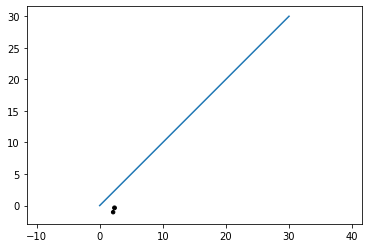

timeout:  False


In [ ]:
# investigate time out 
OA = ObstAvoid()
obst_idx = np.zeros(3)
obst_idx[0:2] = 2

x = Array('d', range(31))
y = Array('d', range(31))
ux = Array('d', range(30))
uy = Array('d', range(30))

p = Process(target=OA.compute_trajectory, name="Compute_traj", args=(obst_idx, x, y, ux, uy))
p.start()
# Wait 5 seconds
time.sleep(5)
timeout = False
if p.is_alive():
    print ("timeout solver")
    timeout = True
    p.terminate()
    p.join()

traj = np.zeros([31,2])
traj[:,0] = x[:]
traj[:,1] = y[:]
OA.plot_trajectory(traj, obst_idx)
print('timeout: ', timeout)

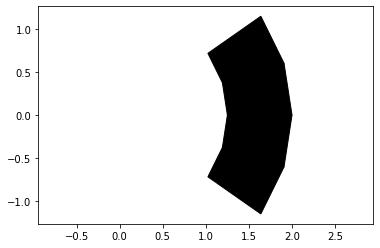

In [ ]:
OA = MILPSOS()
obst_idx = [1,1,1,1,4]
x = Array('d', range(9))
y = Array('d', range(9))
#traj, xm, ym = OA.compute_trajectory(obst_idx, x, y, 0.4, 0.4)
traj = np.zeros([1,4])

OA.plot_trajectory(traj, obst_idx)

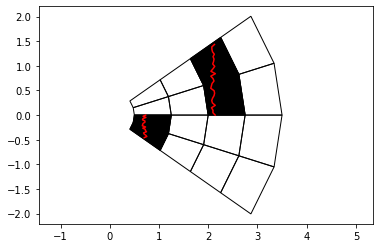

In [ ]:
OA.plot_grid()

1
0.1
0.1
0.06983890609186524 0.1412379360306888 0.08943617257579527


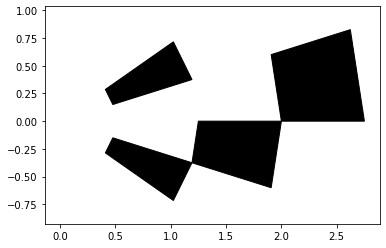

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


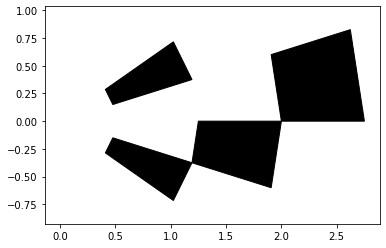

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


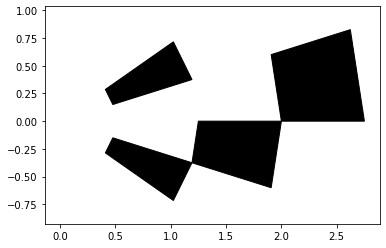

0.4 nan
new S
[[0.55897608 0.        ]
 [0.                nan]]
0.1
0.1 [[1. 0.]
 [0. 1.]]


In [ ]:
# try whole procedure 
# first get some K, S values 
OA = MILPSOS()
K, S = OA.create_LQR()
rho = 0.1
# fix rho and V and find some u and lambda
lbda = 1
print(lbda)
#fix V and lbda and optimize rho and find u 
#rho, K = OA.SOS_compute_2(lbda, S)
print(rho)
#fix u and lbda and optimize rho and find V 
#s, rho = OA.SOS_compute_3(K, lbda)
s=y
S = np.array([[s[0], s[1]], [s[2], s[3]]])
# V is a polynomial
print(rho)
dx, dy, rho_max = OA.get_dxdy(rho, S)
print(dx, dy, rho_max)
obst_idx = np.zeros(5)
# obst_idx[2:] = 1
obst_idx = [0,1,2,0,0]
x = Array('d', range(9))
y = Array('d', range(9))
#traj, xm, ym = OA.compute_trajectory(obst_idx, x, y, dx, dy)
xm ,ym = 0.4,0.4
traj = np.zeros([31,2])
OA.plot_trajectory(traj, obst_idx)
OA.plot_trajectory(traj, obst_idx,x_margin=2*dx, y_margin=2*dy)
# find the largest theta 
theta = np.arctan(max((traj[1:,1] - traj[:-1,1])/(traj[1:,0] - traj[:-1,0])))
ym = ym*np.cos(theta)
OA.plot_trajectory(traj, obst_idx,x_margin=2*xm, y_margin=2*ym)
print(xm, ym)
S = OA.get_new_S(rho_max, xm, ym)
print("new S")
print(S)
#fix V and lbda and optimize rho and find u 
#rho, K = OA.SOS_compute_4(lbda, S, rho)
print(rho)

print(rho, K)

In [ ]:
# ang_discret=5, rng_discret=5 at most 3125 trajectories 
# saved datas 
l = 5**5
obst_array = np.zeros([l,5])
x_array = np.zeros([31,2])
y_array = np.zeros([31,2])
K_array = np.zeros([l,2])
m_array = np.zeros([l,2])
OA = MILPSOS()
i = 0
for a in range(5):
    for b in range(5):
        for c in range(5):
            for d in range(5):
                for e in range(5):
                    obst_idx = [a,b,c,d,e]
                    K, S = OA.create_LQR() # initialize
                    rho = 0.1 # initial guess
                    # fix rho and V and find some u and lambda
                    #lbda = OA.SOS_compute_1(S, rho)
                    #fix V and lbda and optimize rho and find u 
                    #rho, K = OA.SOS_compute_2(lbda, S)
                    #fix u and lbda and optimize rho and find V 
                    #s, rho = OA.SOS_compute_3(K, lbda)
                    S = np.array([[s[0], s[1]], [s[2], s[3]]])
                    # V is a SOS poly
                    dx, dy, rho_max = OA.get_dxdy(rho, S)
                    x = Array('d', range(9))
                    y = Array('d', range(9))
                    # generate trajectory
                    #traj, xm, ym = OA.MILP_compute_traj(obst_idx, x, y, dx, dy)
                    # find the largest theta 
                    theta = np.arctan(max((traj[1:,1] - traj[:-1,1])/(traj[1:,0] - traj[:-1,0])))
                    ym = ym*np.cos(theta)
                    S = OA.get_new_S(rho_max, xm, ym)
                    #fix V and lbda and optimize rho and find u (control law K)
                    #rho, K = OA.SOS_compute_4(5, S, rho)
                    obst_array[i,:] = obst_idx[:]
                    x_array[:] = traj[:]
                    y_array[:] = traj[:]
                    K_array[i,:] = K[1:]
                    m_array[i,0] = xm
                    m_array[i,1] = ym
                    i += 1
                    print("%s of 3125"%(str(i)))
np.savetxt('x.out', x_array, delimiter=',')
np.savetxt('y.out', y_array, delimiter=',')
np.savetxt('K.out', K_array, delimiter=',')
np.savetxt('obst.out', obst_array, delimiter=',')
np.savetxt('m.out', m_array, delimiter=',')
print("Done")
mean_data= ([[0.3, -0.01350756],
       [0.8, -0.01350756],
       [1.2, -0.1550756],
       [1.6, -0.1550756],
       [1.8, -0.5050756],
       [2.0, -0.7850756],
       [2.2, -0.8550756],
       [2.5, -0.8550756],
       [2.8, -0.9050756]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


1 of 3125
2 of 3125
3 of 3125
4 of 3125
5 of 3125
6 of 3125
7 of 3125
8 of 3125
9 of 3125
10 of 3125
11 of 3125
12 of 3125
13 of 3125
14 of 3125
15 of 3125
16 of 3125
17 of 3125
18 of 3125
19 of 3125
20 of 3125
21 of 3125
22 of 3125
23 of 3125
24 of 3125
25 of 3125
26 of 3125
27 of 3125
28 of 3125
29 of 3125
30 of 3125
31 of 3125
32 of 3125
33 of 3125
34 of 3125
35 of 3125
36 of 3125
37 of 3125
38 of 3125
39 of 3125
40 of 3125
41 of 3125
42 of 3125
43 of 3125
44 of 3125
45 of 3125
46 of 3125
47 of 3125
48 of 3125
49 of 3125
50 of 3125
51 of 3125
52 of 3125
53 of 3125
54 of 3125
55 of 3125
56 of 3125
57 of 3125
58 of 3125
59 of 3125
60 of 3125
61 of 3125
62 of 3125
63 of 3125
64 of 3125
65 of 3125
66 of 3125
67 of 3125
68 of 3125
69 of 3125
70 of 3125
71 of 3125
72 of 3125
73 of 3125
74 of 3125
75 of 3125
76 of 3125
77 of 3125
78 of 3125
79 of 3125
80 of 3125
81 of 3125
82 of 3125
83 of 3125
84 of 3125
85 of 3125
86 of 3125
87 of 3125
88 of 3125
89 of 3125
90 of 3125
91 of 3125
92 of 31

[0.0, 2.0, 1.5, 1.0, 1.0]
[ 0.8        -0.01350756]


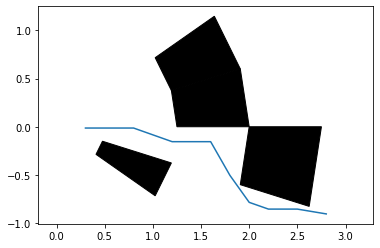

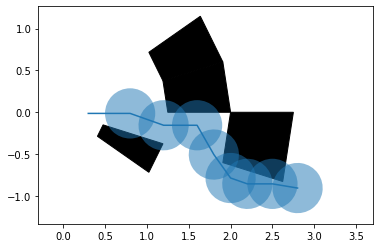

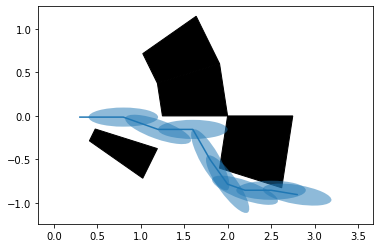

In [ ]:
OA = MILPSOS()
#x_array = np.loadtxt('traj/x.out', delimiter=',')
#y_array = np.loadtxt('traj/y.out', delimiter=',')
#obst_array = np.loadtxt('traj/obst.out', delimiter=',')
#m_array = np.loadtxt('traj/m.out', delimiter=',')

idx = 22
x = x_array[idx,:]
y = y_array[idx,:]
obst_idx = obst_idx = [0., 2., 1.5, 1., 1.]
xm = m_array[idx,0]
ym = m_array[idx,1]
print(obst_idx)
traj = np.zeros([9,2])
traj[7:,0] = x[:]
traj[7:,1] = y[:]
mean_data = np.array(mean_data)
traj = mean_data
print(traj[1,:])
OA.plot_trajectory(traj, obst_idx)
OA.plot_trajectory(traj, obst_idx, x_margin=2*0.3, y_margin=2*0.3)
OA.plot_trajectory(traj, obst_idx, x_margin=2*0.4, y_margin=2*0.11)

In [ ]:
xm

0.4